In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pandas as pd

In [ ]:
os.chdir('/content/drive/MyDrive/Pickleapp/20231129')

In [ ]:
X_train = np.load("train_X.npy")
y_train = np.load("train_y.npy")
X_test = np.load("test_X.npy")
y_test = np.load("test_y.npy")
X_train_noaug = np.load("noaug_train_X.npy")
y_train_noaug = np.load("noaug_train_y.npy")
X_test_noaug = np.load("noaug_test_X.npy")
y_test_noaug = np.load("noaug_test_y.npy")
right_X_train = np.load("right_orient_train_X.npy")
right_y_train = np.load("right_orient_train_y.npy")
right_X_test = np.load("right_orient_test_X.npy")
right_y_test = np.load("right_orient_test_y.npy")


In [ ]:
shape = (270, 480, 3)
points = [1,2,3,4,5,6]
point_cols = [(2 * (p-1), 2 * (p-1) + 1) for p in points]
point_cols = np.array(point_cols).flatten()
num_points = len(points) * 2

y_train = y_train[:, point_cols]
y_test = y_test[:, point_cols]
y_test_noaug = y_test_noaug[:, point_cols]
y_train_noaug = y_train_noaug[:, point_cols]
right_y_train = right_y_train[:, point_cols]
right_y_test = right_y_test[:, point_cols]


In [ ]:
bm = tf.keras.applications.MobileNetV3Small(
    include_top=False,
    weights="imagenet",
    input_shape=shape,
)
bm.trainable=False

In [ ]:
inputs = tf.keras.Input(shape=shape)
x = bm(inputs, training=False)
# x.trainable = False
# x = tf.keras.layers.Conv2D(256, (3, 3), activation='tanh')(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(num_points, activation = 'relu')(x)
model = tf.keras.Model(inputs=inputs, outputs=x)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 270, 480, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 9, 15, 2048)       23564800  
                                                                 
 flatten_3 (Flatten)         (None, 276480)            0         
                                                                 
 dropout_3 (Dropout)         (None, 276480)            0         
                                                                 
 dense_3 (Dense)             (None, 12)                3317772   
                                                                 
Total params: 26882572 (102.55 MB)
Trainable params: 3317772 (12.66 MB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                loss=tf.keras.losses.MeanSquaredError(),
                metrics=['mae'])

In [ ]:
print(len(X_train_noaug), len(X_test_noaug))

476 124


In [ ]:
callback = tf.keras.callbacks.EarlyStopping('val_loss', patience=10, restore_best_weights = True)
np.random.seed(42)
model.fit(X_train_noaug, y_train_noaug, epochs = 400, batch_size = 32, validation_data=(X_test_noaug, y_test_noaug), callbacks = [callback])

Epoch 1/200
15/15 [==============================] - 10s 390ms/step - loss: 182081.6562 - mae: 317.5600 - val_loss: 60489.8750 - val_mae: 172.7387
Epoch 2/200
15/15 [==============================] - 4s 276ms/step - loss: 40928.9844 - mae: 149.3003 - val_loss: 20699.9844 - val_mae: 100.6165
Epoch 3/200
15/15 [==============================] - 5s 316ms/step - loss: 19558.9785 - mae: 102.8962 - val_loss: 9126.4648 - val_mae: 64.4665
Epoch 4/200
15/15 [==============================] - 5s 311ms/step - loss: 11559.0938 - mae: 80.6867 - val_loss: 6287.7451 - val_mae: 55.7535
Epoch 5/200
15/15 [==============================] - 4s 279ms/step - loss: 9162.1348 - mae: 73.6294 - val_loss: 3490.1030 - val_mae: 42.3759
Epoch 6/200
15/15 [==============================] - 4s 284ms/step - loss: 8249.1211 - mae: 71.9594 - val_loss: 2669.5789 - val_mae: 37.4440
Epoch 7/200
15/15 [==============================] - 4s 283ms/step - loss: 6886.0220 - mae: 65.3945 - val_loss: 2069.3538 - val_mae: 31.5284


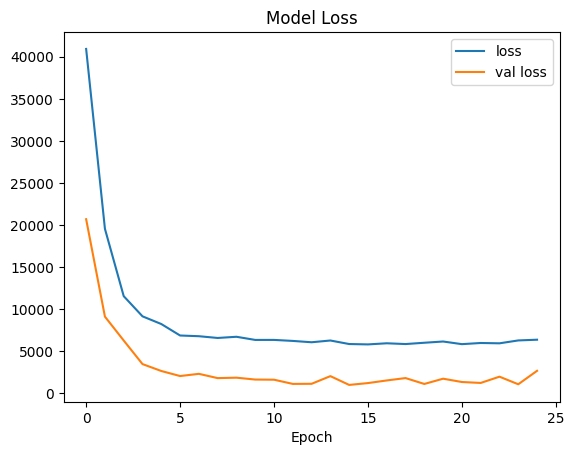

In [ ]:
# plot the history of the loss
start = 1
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']
plt.plot(loss[start:], label="loss")
plt.plot(val_loss[start:], label='val loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.legend()


In [ ]:
# test
model.evaluate(X_test_noaug, y_test_noaug)

4/4 [==============================] - 1s 205ms/step - loss: 1014.9949 - mae: 24.6755


[1014.994873046875, 24.675485610961914]

In [ ]:
# training
model.evaluate(X_train_noaug, y_train_noaug)

15/15 [==============================] - 3s 214ms/step - loss: 832.4873 - mae: 22.7558


[832.4873046875, 22.755794525146484]

In [ ]:
# all test data
model.evaluate(X_test, y_test)

12/12 [==============================] - 3s 211ms/step - loss: 9678.5723 - mae: 62.4371


[9678.572265625, 62.43714141845703]

In [ ]:
# all training data
model.evaluate(X_train, y_train)

45/45 [==============================] - 10s 213ms/step - loss: 9604.9297 - mae: 61.8742


[9604.9296875, 61.874202728271484]

In [ ]:
# unfreeze model weights for saving
bm.trainable = True
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 270, 480, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 9, 15, 2048)       23564800  
                                                                 
 flatten_3 (Flatten)         (None, 276480)            0         
                                                                 
 dropout_3 (Dropout)         (None, 276480)            0         
                                                                 
 dense_3 (Dense)             (None, 12)                3317772   
                                                                 
Total params: 26882572 (102.55 MB)
Trainable params: 26837132 (102.38 MB)
Non-trainable params: 45440 (177.50 KB)
_________________________________________________________________


In [ ]:
# save weights
from google.colab import files
filename = 'MobileNetV3Small_flips_only.h5'
model.save_weights(filename)
files.download(filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>